<h1> Introdução </h1>

<p> O tema selecionado para análise foi a <b>Avaliação de Risco de Crédito</b> por sua relevância no mercado econômico e financeiro bem como por sua complexidade, fomentando a aplicação comparativa de diversas técnicas de análises preditivas </p>

<h3> Fonte de Dados </h3>
<p> A base de dados utilizada neste estudo foi obtida no site de competições em ciência de dados kaggle.com, <a href=https://www.kaggle.com/wendykan/lending-club-loan-data/home>Lending Club Load Data </a> e consiste em um conjunto de dados completo de empréstimos concedidos a clientes entre 2007-2015, incluindo o status atual do empréstimo (calculado até à data de publicação do dataset). 
<br>Os recursos adicionais incluem pontuação de crédito, número de consultas financeiras, endereço entre outros. O arquivo é uma tabela de cerca de 890 mil observações e 75 variáveis. Um dicionário de dados (table metadata) é fornecido em um arquivo separado </p>

<h3>Objetivo</h3>
<p>Contruir um modelo que preveja se um pedido de empréstimo será honrado (loan_status="Fully Paid" ou "Current") ou não (loan_status="Demais valores")</p>

<h3>Metodologia</h3>
<p>A metodologia de análise será composta das seguintes etapas</p>
<ol>
    <li>Avaliação Preliminar</li>
    <li>Análise Descritiva</li>
    <li>Limpeza e Tratamento dos Dados</li>
    <li>Treinamento do modelo: <b>Regressão Logística</b></li>
    <li>Treinamento do modelo: <b>Árvore de Decisão</b></li>
    <li>Comparação de Performance</li>
    <li>Conclusão</li>
</ol>



<h2>1 - Avaliação Preliminar</h2>
<ul>
    <li>Leitura da base de dados</li>
    <li>Validação do tamanho da base</li>
    <li>Compreensão das variáveis disponíveis</li>
    <li>Quantificação dos valores faltantes (missing values)</li>
    <li>Identificação da variávei alvo <b>(target)</b></li>
</ul>


<h3>Leitura da base de dados</h3>

In [1]:
#importing python data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import matplotlib.font_manager as fm

#configuring appearence styles
sns.set_style('whitegrid')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline

fontsize2use = 12   
fontprop = fm.FontProperties(size=fontsize2use)

# Disable display truncation 
pd.set_option('display.max_columns', 0)
pd.set_option('display.max_rows', 500)

In [2]:
raw_data = pd.read_csv('../loan.csv',low_memory=False)

<h4>Visualização do tamanho e dimensões da base </h4>

In [3]:
def print_shape(dataframe):
    shape = dataframe.shape
    print("As dimensões da base são: \n\n \
            Quantidade de Observações: {} \n \
            Quantidade de Variáveis  : {}".format(shape[0],shape[1]))
    
print_shape(raw_data)

As dimensões da base são: 

             Quantidade de Observações: 887379 
             Quantidade de Variáveis  : 74


<h4> Retira uma amostra aleatória do Dataset para reduzir consumo de memória </h4>
<p>O tamanho da amostra corresponde a 25% do tamanho original do dataset</p>

In [4]:
df = raw_data.sample(frac=.10).copy()
print_shape(df)

As dimensões da base são: 

             Quantidade de Observações: 88738 
             Quantidade de Variáveis  : 74


<h4>Visualização dos nomes e metadados das colunas para compreensão das variáveis disponíveis</h4> 
<p>Neste ponto, o arquivo de metadados disponibilizado pelo kaggle é utilizado para compreender o significado de cada variável existente no dataset </p>

In [5]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [6]:
df_metadata = pd.read_excel(io='../LCDataDictionary.xlsx').dropna()
df_metadata.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan application
1,annual_inc,The self-reported annual income provided by the borrower during registration.
2,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
6,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
7,desc,Loan description provided by the borrower
8,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
9,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"


<h4> Quantificação dos valores faltantes (missing)</h4>

In [7]:
#Definição de função de avaliação quantitativa de valores ausentes em um dado Pandas.DataFrame
def missing_values(dataframe):
        mis_val = dataframe.isnull().sum()
        mis_val_percent = 100 * (dataframe.isnull().sum() / len(dataframe))
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
            columns = {0 : 'Missing Values', 1 : '% of Total Values'}
        )
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0
        ].sort_values(
            '% of Total Values', ascending=False
        ).round(1)
        
        qtd_columns_over_limit = len(mis_val_table_ren_columns[mis_val_table_ren_columns['% of Total Values']>70.0])
        
        print("O Dataset possui " + str(df.shape[1]) + " colunas.\n"
                + str(mis_val_table_ren_columns.shape[0]) + 
                " Colunas possuem valores ausentes. \n" 
                + str(qtd_columns_over_limit) +
                " Colunas cuja proporção de valores ausentes ultrapassa 70% das observações")
        
        return mis_val_table_ren_columns
    
#Quantifica os valores faltantes no dataset estudado    
missing_statistics = missing_values(df)
missing_statistics[missing_statistics['% of Total Values']>70.0]

O Dataset possui 74 colunas.
38 Colunas possuem valores ausentes. 
20 Colunas cuja proporção de valores ausentes ultrapassa 70% das observações


,Missing Values,% of Total Values
dti_joint,88685,99.9
verification_status_joint,88684,99.9
annual_inc_joint,88684,99.9
il_util,86942,98.0
mths_since_rcnt_il,86737,97.7
total_cu_tl,86683,97.7
inq_fi,86683,97.7
all_util,86683,97.7
max_bal_bc,86683,97.7
open_rv_24m,86683,97.7


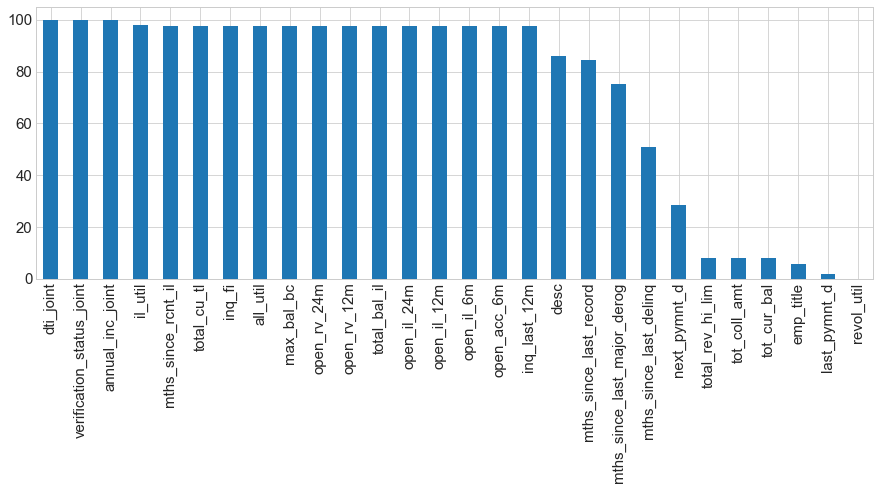

In [8]:
plt.Figure(figsize=(15,5))
missing_statistics[
                   missing_statistics['% of Total Values'] > 0.0
                  ]['% of Total Values'].plot(
                        kind='bar',
                        figsize=(15,5),
                        fontsize=15
                    )
plt.show()

<p> O gráfico acima mostra que a base de dados possui algumas colunas com um percentual muito alto de observações nulas ou faltantes (acima de 75%, exemplos: `dti_joint`,`annual_inc_joint`,`verification_status_joint`) e que deverão ser tratadas/removidas para a modelagem</p>

In [9]:
#exclusão de colunas com mais de 70% de valores ausentes (missing)
df.drop(labels=missing_statistics[missing_statistics['% of Total Values'] > 70.0].index,
        axis=1,
        inplace=True)
print_shape(df)

As dimensões da base são: 

             Quantidade de Observações: 88738 
             Quantidade de Variáveis  : 54


<h4> Identificação da variávei alvo (target)</h4>
<p>A coluna que contém a variável alvo do estudo é a <b>Loan Status</b>. Esta variável representa a situação corrente do título de empréstimo no momento da publicação do dataset (Current, Late, Fully Paid, etc...).</p>

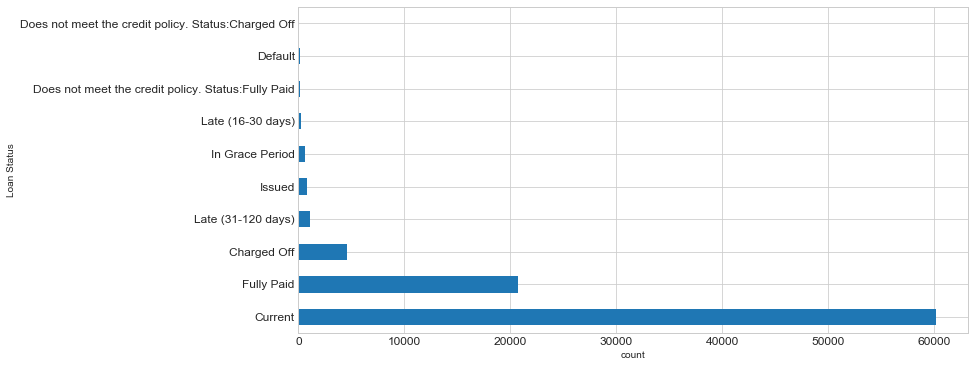

In [10]:
plt.figure(figsize=(12,6))
plt.ylabel('Loan Status')
plt.xlabel('count')
df['loan_status'].value_counts().plot(kind='barh',grid=True,fontsize=12)
plt.show()

Taxa de Bons Empréstimos: 91.18%
Taxa de Maus Empréstimos: 8.82%


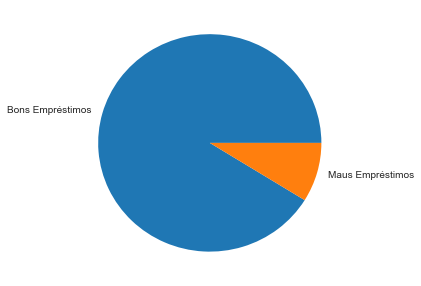

In [11]:
#Calcula proporção de empréstimos "Bons" e "Maus"
good_loan = len(df[(df.loan_status=='Fully Paid') |
                   (df.loan_status=='Current')])

good_loan_ratio = good_loan/len(df)
bad_loan_ratio = 1-good_loan_ratio

print("Taxa de Bons Empréstimos: %.2f%%" % (good_loan_ratio*100))
print("Taxa de Maus Empréstimos: %.2f%%" % (bad_loan_ratio*100))

pie_target_ratio = pd.Series({
    "Bons Empréstimos":(good_loan_ratio*100),
    "Maus Empréstimos":(bad_loan_ratio*100)
})

plt.figure(figsize=(5,5))
plt.pie(x=pie_target_ratio,labels=pie_target_ratio.index)
plt.show()

<h4>Observação</h4>
<p>A proporção acima mostra claramente que se trata de um caso em que a classe alvo está desbalanceada. Isto significa que uma determinada classe de observações da variável alvo (loan_status) apresenta uma proporção muito superior superior do que as demais na base e acaba dominando o modelo.</p>
<p> Esta característica deverá ser tratada ao longo do estudo, utilizando técnicas apropriadas </p>

In [12]:
#Define a variável target (alvo)
## 1 = Empréstimo Honrado ("Fully Paid" ou "Current")
## 0 = Empréstimo Não Honrado (Demais Categorias)
df['target'] = df['loan_status'].apply(lambda value: 1 if value in ("Fully Paid","Current") else 0)
df.drop('loan_status',axis=1,inplace=True)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
822746,40984472,43860391,28000.0,28000.0,28000.0,60 months,12.69,632.66,C,C2,ENGINEERING,6 years,MORTGAGE,96000.0,Source Verified,Mar-2015,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,Debt consolidation,756xx,TX,18.25,0.0,Oct-1989,0.0,NaN,12.0,0.0,59454.0,98.3,23.0,w,24469.64,24469.64,6287.12,6287.12,3530.36,2756.76,0.0,0.0,0.0,Jan-2016,632.66,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,229528.0,60500.0,1
825940,41870743,44817478,18000.0,18000.0,18000.0,60 months,16.55,443.01,D,D2,Project manager,10+ years,MORTGAGE,220000.0,Source Verified,Mar-2015,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,Debt consolidation,117xx,NY,11.65,1.0,Jul-1997,0.0,14.0,15.0,0.0,27561.0,89.5,25.0,w,15926.97,15926.97,4413.55,4413.55,2073.03,2340.52,0.0,0.0,0.0,Jan-2016,443.01,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,551691.0,30800.0,1
20795,644119,824268,5500.0,5500.0,5500.0,36 months,10.74,179.39,B,B4,cumberlad farms,10+ years,MORTGAGE,60000.0,Not Verified,Jan-2011,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Rafs credit card loan,028xx,RI,15.62,0.0,Dec-1999,1.0,70.0,18.0,1.0,12835.0,43.7,29.0,f,0.00,0.00,6170.16,6170.16,5500.01,670.15,0.0,0.0,0.0,Jul-2012,3308.50,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1
384633,16882417,19004968,23675.0,23675.0,23575.0,60 months,19.52,620.94,E,E2,Inteligence Analyst,10+ years,MORTGAGE,54000.0,Source Verified,May-2014,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Credit card refinancing,290xx,SC,31.42,0.0,Aug-2002,0.0,52.0,7.0,0.0,19698.0,81.1,16.0,f,18473.72,18395.69,11797.86,11748.03,5201.28,6596.58,0.0,0.0,0.0,Dec-2015,620.94,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,236697.0,24300.0,1
487440,67375153,72186866,21000.0,21000.0,21000.0,36 months,11.99,697.41,C,C1,HR Spec,10+ years,OWN,130000.0,Verified,Dec-2015,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,Debt consolidation,226xx,VA,24.30,0.0,Jan-2001,0.0,NaN,24.0,0.0,47415.0,81.3,36.0,w,21000.00,21000.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,NaN,0.00,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,591596.0,58300.0,1


<h2>2 - Análise Descritiva</h2>
<ul>
    <li>Medidas de Centralidade/Variabilidade (variáveis numéricas)</li>
    <li>Medidas de Frequência/Classes Distintas (variáveis categóricas)</li>
</ul>


<h4>Avaliação dos tipos de variáveis (Numéricas/Categóricas)</h4>
<p>Por definição (pandas.DataFrame), as variáveis numéricas no Dataset são classificadas como `float64` ou `int64`, enquanto as categóricas são classificadas como `object`</p>

As dimensões da base são: 

             Quantidade de Observações: 88738 
             Quantidade de Variáveis  : 54


Quantidade de cada Tipo de Dados existente na base 

float64    31
object     20
int64       3
dtype: int64


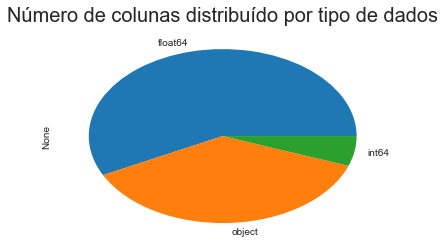

In [13]:
# Quantidade de tipos de dados diferentes no dataset
print_shape(df)
print("\n")


#função para exibir graficamente a composição de dados de um dado dataset
def print_dtypes(dataframe):
    print("Quantidade de cada Tipo de Dados existente na base \n")
    print(dataframe.dtypes.value_counts())

    plt.figure()
    dataframe.dtypes.value_counts().plot(kind='pie')
    plt.title('Número de colunas distribuído por tipo de dados',fontsize=20)
    
print_dtypes(df)

<p>O gráfico acima nos mostra que temos uma quantidade considerável de colunas com valores do tipo `object` (variáveis categóricas) que deverão ser tratadas e/ou removidas para uso no modelo </p>

<h4>Avaliação das variáveis categóricas</h4>
<p>Quantificação e frequência das classes únicas existentes em cada variável categórica do dataset</p>

Variáveis categóricas e ocorrências distintas pela base 

                     qtd_unicos  perc_unicos
url                       88738   100.000000
emp_title                 43144    48.619532
title                      8678     9.779350
zip_code                    871     0.981541
earliest_cr_line            614     0.691925
issue_d                     103     0.116072
last_pymnt_d                 96     0.108184
last_credit_pull_d           94     0.105930
next_pymnt_d                 76     0.085645
addr_state                   50     0.056346
sub_grade                    35     0.039442
purpose                      14     0.015777
emp_length                   12     0.013523
grade                         7     0.007888
home_ownership                5     0.005635
verification_status           3     0.003381
term                          2     0.002254
initial_list_status           2     0.002254
pymnt_plan                    2     0.002254
application_type              2     0.0022

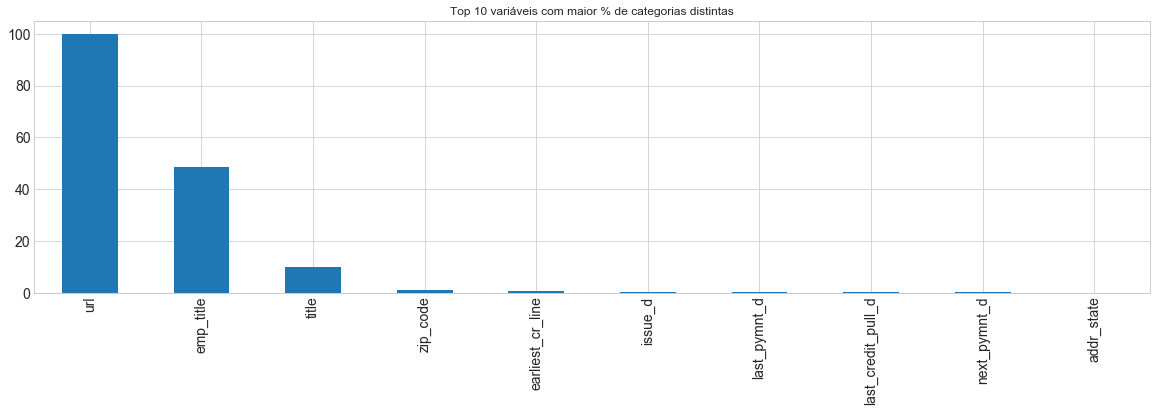

In [14]:
category = pd.DataFrame({ 'qtd_unicos': df.select_dtypes(include=['object']).apply(pd.Series.nunique, axis = 0)})  
category['perc_unicos'] = category['qtd_unicos'].apply(lambda x: (float(x)/len(df))*100)

print("Variáveis categóricas e ocorrências distintas pela base \n")
print(category.sort_values(by='perc_unicos',ascending=False))

#plota o gráfico de barras por percentual de categorias únicas
category['perc_unicos'].sort_values(ascending=False).head(10).plot.bar(
    figsize=(20,5),
    fontsize=14,
    title='Top 10 variáveis com maior % de categorias distintas')

<p> O gráfico acima nos mostra que algumas variáveis possuem alta variabilidade (número extremamente alto de categorias distintas). É o caso das variáveis `url`,`emp_title`,`title` e `title`. Estas variáveis possuem alto número de categorias distintas, o que indica aleatoriedade e prejudica a assertividade do modelo.<p>

<p> Estas variáveis serão desconsideradas na análise </p>

As dimensões da base são: 

             Quantidade de Observações: 88738 
             Quantidade de Variáveis  : 51


Quantidade de cada Tipo de Dados existente na base 

float64    31
object     17
int64       3
dtype: int64


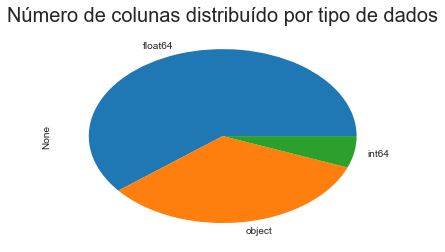

In [15]:
df.drop(['url','emp_title','title'],axis=1,inplace=True)
print_shape(df)
print("\n")
print_dtypes(df)

In [16]:
#função para plotar uma lista de gráficos de pizza com a composição de frequencias para cada variávei categórica, 
## dado um dataframe
def plot_categories_distribution(dataframe):
    categories = dataframe.select_dtypes(include=['object']).columns.sort_values()
    m = len(categories)
    fig,axes = plt.subplots(6,int(m/5),sharey=True,figsize=(10,15))

    
    for n in range(len(axes.flat)):
        try:
            ax = axes.flat[n]
            item = categories[n]
            group = dataframe.groupby(item).size()

            ax.pie(group)
            ax.set_title(item)    
        except:
            #caso não exista mais categorias a iterar, finaliza a execução da função
            return

In [17]:
df.select_dtypes(include=['object']).describe()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
count,88738,88738,88738,88738,88738,88738,88738,88738,88738,88738,88738,88735,88738,86998,63448,88734,88738
unique,2,7,35,12,5,3,103,2,14,871,50,614,2,96,76,94,2
top,36 months,B,B4,10+ years,MORTGAGE,Source Verified,Oct-2015,n,debt_consolidation,945xx,CA,Aug-2000,f,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL
freq,62241,25365,5621,29362,44356,32852,4881,88737,52185,1020,12884,676,45518,47060,55376,73022,88684


<p> A tabela acima mostra de forma resumida a composição de cada variável categórica existente. Estão consolidadas medidas básicas como 
<ul> 
    <li>Quantidade (count) </li> 
    <li> Quantidade de Valores distintos (unique)</li> 
    <li>Classe mais comum (top)</li>
    <li>Frequência da classe mais comum (freq)</li>
</ul>
</p>
<p> É possível verificar que muitas variáveis são compostas de texto puro/alta variação de categorias, que deverão ser codificados e/ou removidos para treinamento do modelo </p>
<p> Além disso, algumas variáveis apresentam variação quase nula na base (ex.: `pymnt_plan` e `application_type`), o que indica que tais variáveis deverão ser removidas </p>

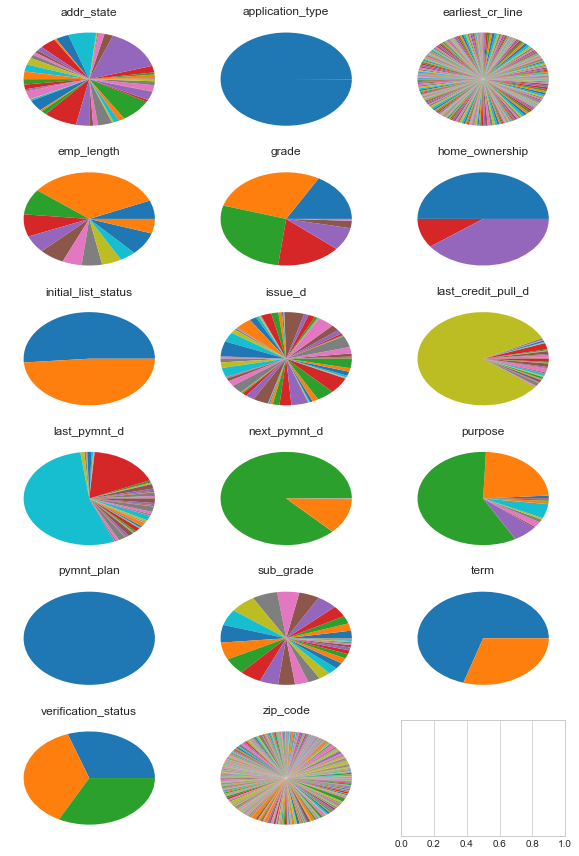

In [18]:
plot_categories_distribution(df)

<p> A relação de gráficos acima ilustra de forma visual a frequência por categoria em cada uma das variáveis categóricas do modelo </p>

In [19]:
df.select_dtypes(include=['object']).head(10)

,term,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
822746,60 months,C,C2,6 years,MORTGAGE,Source Verified,Mar-2015,n,debt_consolidation,756xx,TX,Oct-1989,w,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL
825940,60 months,D,D2,10+ years,MORTGAGE,Source Verified,Mar-2015,n,debt_consolidation,117xx,NY,Jul-1997,w,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL
20795,36 months,B,B4,10+ years,MORTGAGE,Not Verified,Jan-2011,n,credit_card,028xx,RI,Dec-1999,f,Jul-2012,NaN,Jan-2016,INDIVIDUAL
384633,60 months,E,E2,10+ years,MORTGAGE,Source Verified,May-2014,n,credit_card,290xx,SC,Aug-2002,f,Dec-2015,Feb-2016,Jan-2016,INDIVIDUAL
487440,36 months,C,C1,10+ years,OWN,Verified,Dec-2015,n,debt_consolidation,226xx,VA,Jan-2001,w,NaN,Feb-2016,Jan-2016,INDIVIDUAL
792312,36 months,B,B3,10+ years,MORTGAGE,Verified,Apr-2015,n,debt_consolidation,140xx,NY,Feb-1997,w,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL
817276,36 months,A,A2,4 years,OWN,Not Verified,Mar-2015,n,credit_card,349xx,FL,Dec-2005,w,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL
765154,60 months,F,F4,10+ years,MORTGAGE,Source Verified,Apr-2015,n,debt_consolidation,932xx,CA,Jul-1990,w,May-2015,NaN,Jan-2016,INDIVIDUAL
309362,36 months,C,C2,8 years,RENT,Source Verified,Sep-2014,n,credit_card,900xx,CA,Dec-2007,f,Aug-2015,NaN,Jan-2016,INDIVIDUAL
859118,60 months,B,B3,10+ years,MORTGAGE,Source Verified,Jan-2015,n,debt_consolidation,148xx,NY,Jun-2003,w,Dec-2015,Feb-2016,Jan-2016,INDIVIDUAL


<h4>Avaliação das variáveis numéricas</h4>
<p>Medidas de Centralidade e Variabilidade existentes em cada variável numérica do dataset. </p>

In [20]:
df.select_dtypes(include=['float64','int64']).columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'target'],
      dtype='object')

In [21]:
def plot_numeric_histogram(dataframe):
    categories = dataframe.select_dtypes(include=['float64','int64']).columns
    m = len(categories)
    fig,axes = plt.subplots(6,int(m/5),figsize=(30,35))

    
    for n in range(len(axes.flat)-1):
        try:
            ax = axes.flat[n]
            item = categories[n]
            group = dataframe.groupby(item).size()
        
            ax.hist(group,bins=10,)
            ax.set_title(item,fontsize=10)  
        except:
            #caso não encontre mais itens  para iterar
            return

In [22]:
df.select_dtypes(include=['float64','int64']).describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
count,8.873800e+04,8.873800e+04,88738.000000,88738.000000,88738.000000,88738.000000,88738.000000,8.873800e+04,88738.000000,88735.000000,88735.000000,43386.000000,88735.000000,88735.000000,8.873800e+04,88682.000000,88735.000000,88738.000000,88738.000000,88738.000000,88738.000000,88738.000000,88738.000000,88738.000000,88738.000000,88738.000000,88738.000000,88719.000000,88738.0,88735.000000,81737.000000,8.173700e+04,8.173700e+04,88738.000000
mean,3.248437e+07,3.501998e+07,14717.679855,14702.383421,14659.981590,13.239323,435.714155,7.487569e+04,18.144180,0.310993,0.694517,34.195455,11.529554,0.199177,1.680866e+04,54.996967,25.242926,8377.009159,8373.763133,7538.293997,7496.490233,5741.950372,1749.108517,0.387048,46.848061,4.955758,2149.336341,0.013932,1.0,0.004790,205.189767,1.390371e+05,3.186129e+04,0.911751
std,2.279253e+07,2.407712e+07,8401.472284,8395.331130,8410.985997,4.375981,243.079376,6.455964e+04,9.062713,0.849625,0.998445,21.960433,5.305279,0.635372,2.154870e+04,23.901664,11.806808,8465.089390,8461.870091,7837.097768,7812.069057,6600.054630,2087.150345,4.003274,424.322385,64.296915,4763.498405,0.127348,0.0,0.074686,1656.511291,1.532232e+05,3.199947e+04,0.283658
min,5.473400e+04,7.065100e+04,725.000000,725.000000,0.000000,5.320000,22.510000,1.770000e+03,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,9.227558e+06,1.094970e+07,8000.000000,8000.000000,8000.000000,9.990000,260.550000,4.500000e+04,11.910000,0.000000,0.000000,15.000000,8.000000,0.000000,6.405250e+03,37.600000,17.000000,0.000000,0.000000,1918.700000,1900.520000,1201.350000,442.012500,0.000000,0.000000,0.000000,279.160000,0.000000,1.0,0.000000,0.000000,2.976700e+04,1.390000e+04,1.000000
50%,3.446321e+07,3.712125e+07,13000.000000,13000.000000,12900.000000,12.990000,381.040000,6.444000e+04,17.640000,0.000000,0.000000,31.000000,11.000000,0.000000,1.180850e+04,55.900000,24.000000,6427.315000,6422.750000,4885.675000,4851.235000,3222.620000,1072.490000,0.000000,0.000000,0.000000,462.390000,0.000000,1.0,0.000000,0.000000,7.935100e+04,2.370000e+04,1.000000
75%,5.468841e+07,5.824909e+07,20000.000000,20000.000000,20000.000000,16.200000,570.840000,9.000000e+04,23.970000,0.000000,1.000000,50.000000,14.000000,0.000000,2.074200e+04,73.600000,32.000000,13624.900000,13614.710000,10572.630000,10507.392500,7995.690000,2229.717500,0.000000,0.000000,0.000000,826.430000,0.000000,1.0,0.000000,0.000000,2.075390e+05,3.960000e+04,1.000000
max,6.861658e+07,7.354283e+07,35000.000000,35000.000000,35000.000000,28.990000,1408.130000,8.253000e+06,1092.520000,26.000000,16.000000,152.000000,84.000000,86.000000,1.190046e+06,148.000000,124.000000,35000.000000,35000.000000,54329.489934,54329.490000,35000.010000,23172.310000,358.680000,23184.330000,5192.990000,36224.170000,3.000000,1.0,3.000000,102841.000000,3.164353e+06,1.314900e+06,1.000000


<p> A tabela acima mostra de forma resumida um conjunto básico de medidas descritivas para cada variávei numérica existente no dataset. Entre elas:
<ul> 
    <li>Quantidade (count) </li> 
    <li> Média (mean)</li> 
    <li> Desvio Padrão (std)</li>
    <li> Valores Máximos e mínimos (max/min)</li>
    <li> Percentis (25%, 50%, 75%) </li>
</ul>
</p>

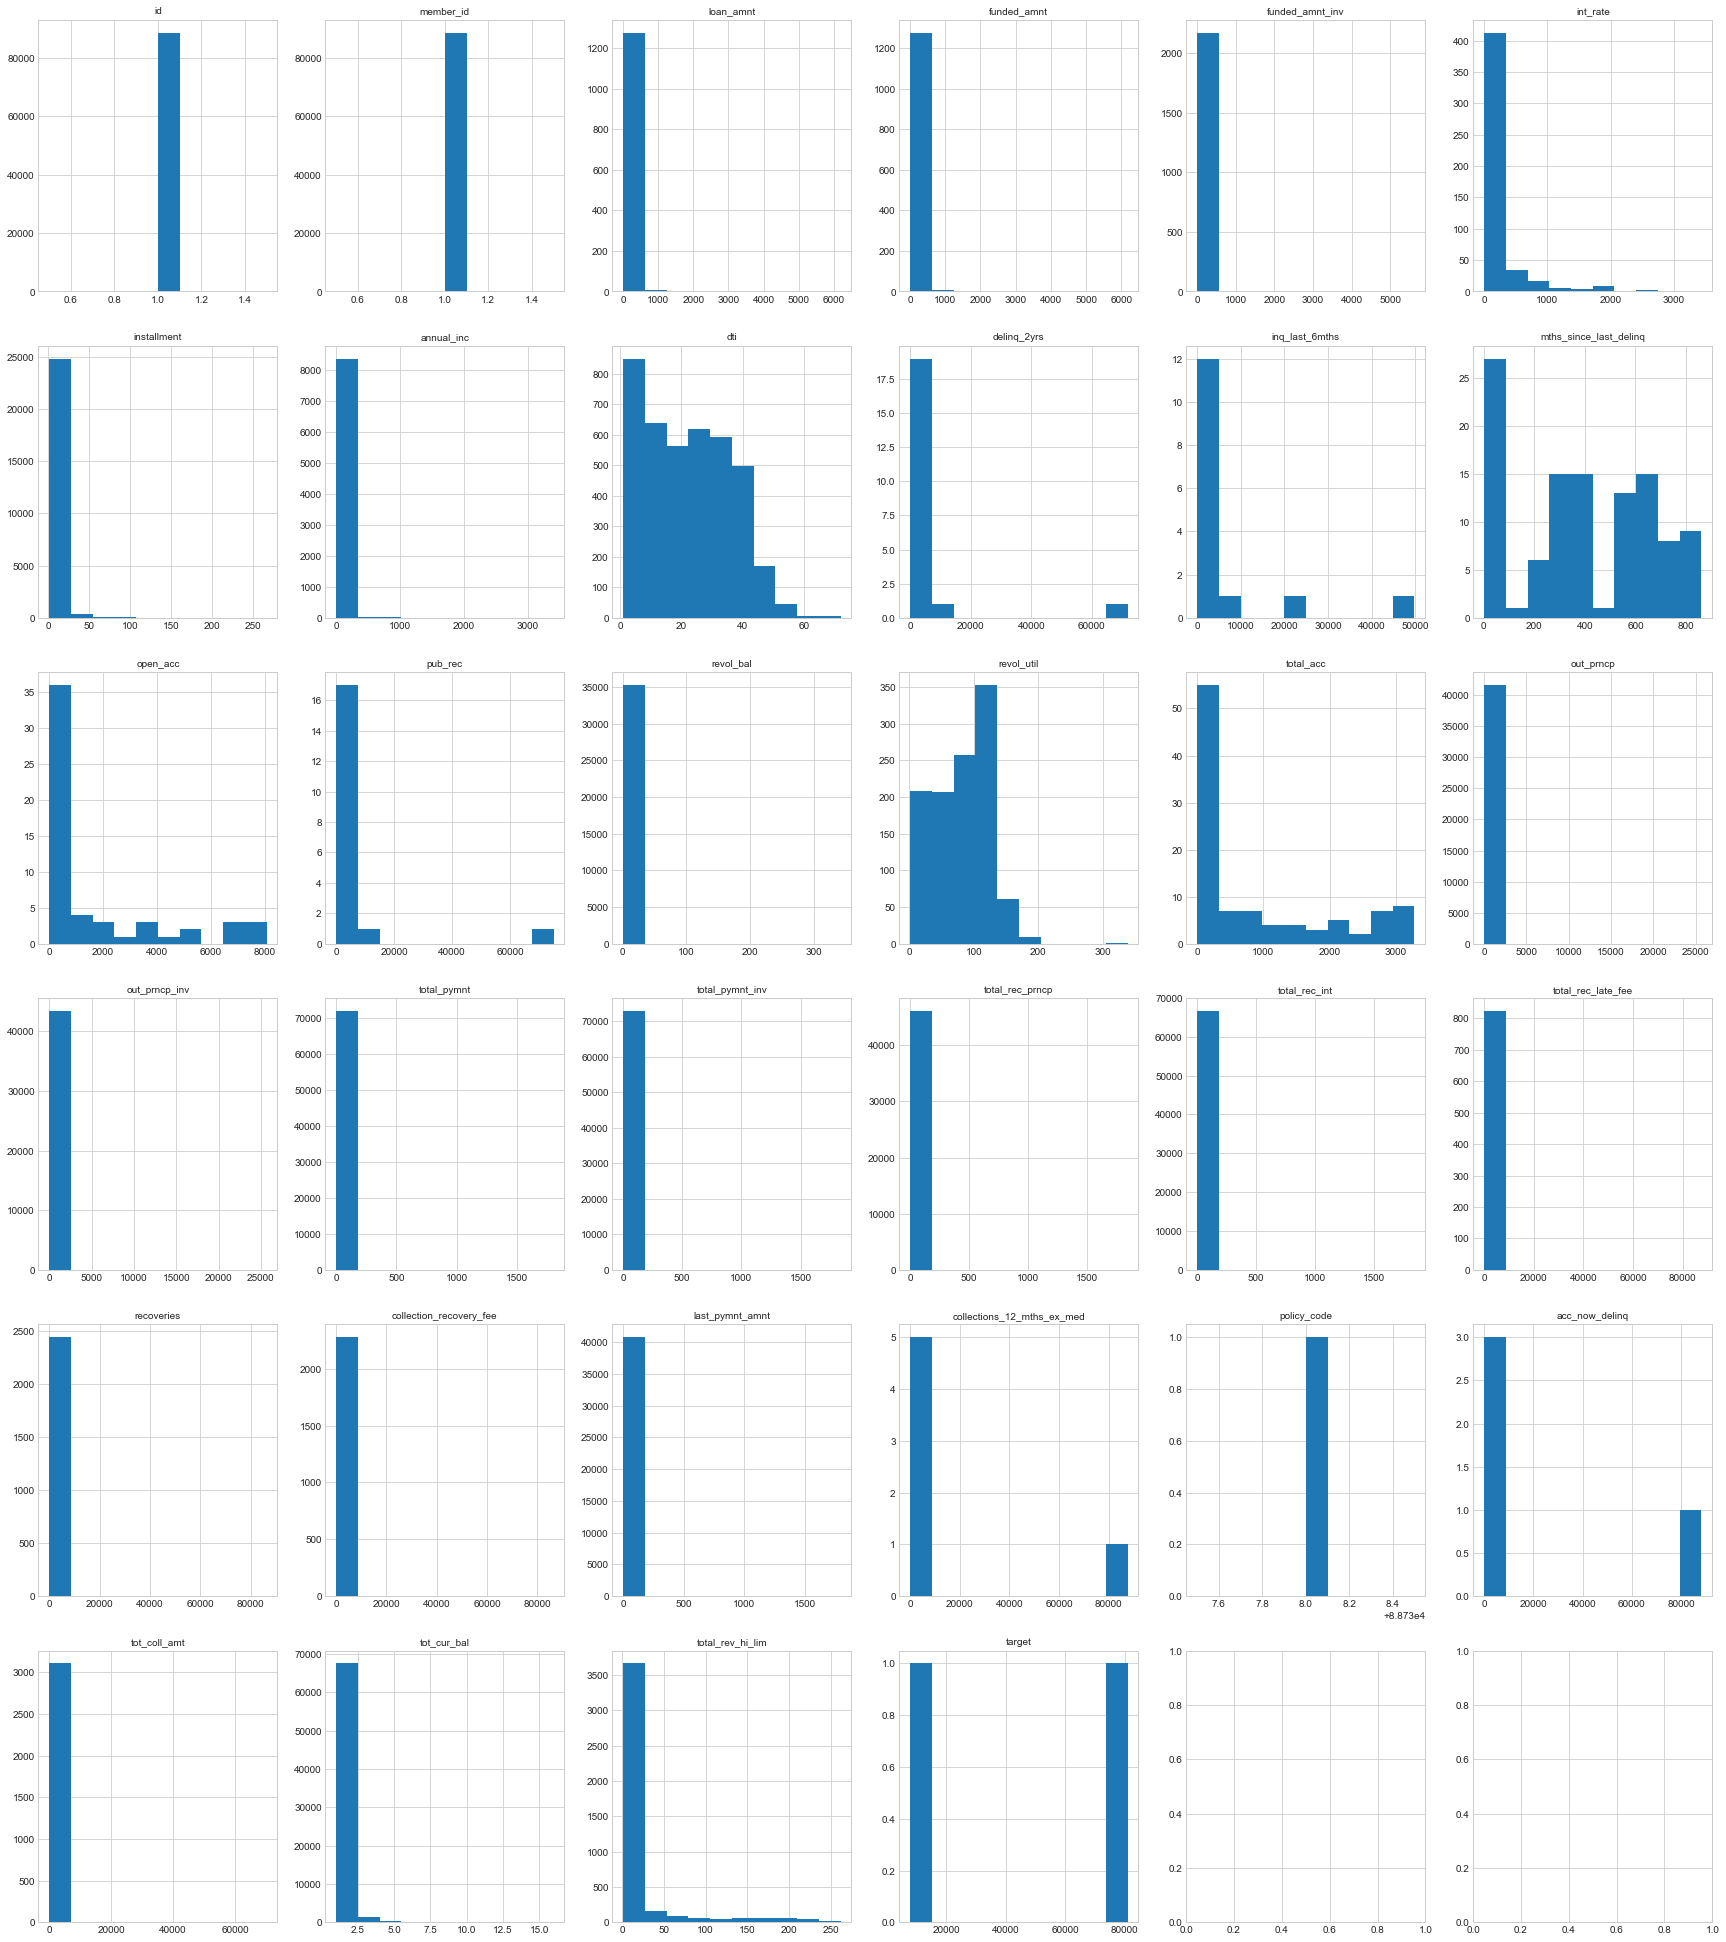

In [25]:
plot_numeric_histogram(df)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88738 entries, 822746 to 140070
Data columns (total 51 columns):
id                            88738 non-null int64
member_id                     88738 non-null int64
loan_amnt                     88738 non-null float64
funded_amnt                   88738 non-null float64
funded_amnt_inv               88738 non-null float64
term                          88738 non-null object
int_rate                      88738 non-null float64
installment                   88738 non-null float64
grade                         88738 non-null object
sub_grade                     88738 non-null object
emp_length                    88738 non-null object
home_ownership                88738 non-null object
annual_inc                    88738 non-null float64
verification_status           88738 non-null object
issue_d                       88738 non-null object
pymnt_plan                    88738 non-null object
purpose                       88738 non-null obje

<p>Análise da correlação das variáveis numéricas com a variável alvo (target)</p>

In [24]:
#removendo variáveis que não servirão para o estudo
df.drop(['id','member_id','zip_code'],axis=1,inplace=True)
df.dropna()

corr = df.corr()['target'].sort_values()

# Display correlations
print('Correlações mais Positivas:\n\n', corr.tail(10))
print('\nCorrelações mais negativas:\n\n', corr.head(10))

Correlações mais Positivas:

 tot_cur_bal         0.038314
total_rev_hi_lim    0.042173
total_pymnt         0.067701
total_pymnt_inv     0.071660
last_pymnt_amnt     0.110959
total_rec_prncp     0.116266
out_prncp_inv       0.129786
out_prncp           0.129796
target              1.000000
policy_code              NaN
Name: target, dtype: float64

Correlações mais negativas:

 recoveries                -0.354881
collection_recovery_fee   -0.247746
int_rate                  -0.165014
total_rec_late_fee        -0.150151
inq_last_6mths            -0.103089
revol_util                -0.043668
total_rec_int             -0.041011
dti                       -0.026132
installment               -0.009091
delinq_2yrs               -0.005731
Name: target, dtype: float64


<h2>3 - Limpeza e Tratamento dos Dados</h2>
<ul>
   <li>Transformação das variáveis categóricas relevantes (encoding e hot-encoding)</li>
   <li>Normalização/Agrupamento das variáveis numéricas </li>
</ul>


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88738 entries, 822746 to 140070
Data columns (total 48 columns):
loan_amnt                     88738 non-null float64
funded_amnt                   88738 non-null float64
funded_amnt_inv               88738 non-null float64
term                          88738 non-null object
int_rate                      88738 non-null float64
installment                   88738 non-null float64
grade                         88738 non-null object
sub_grade                     88738 non-null object
emp_length                    88738 non-null object
home_ownership                88738 non-null object
annual_inc                    88738 non-null float64
verification_status           88738 non-null object
issue_d                       88738 non-null object
pymnt_plan                    88738 non-null object
purpose                       88738 non-null object
addr_state                    88738 non-null object
dti                           88738 non-null fl

<p> Primeiramente, os valores de data serão convertidos em inteiros pelo número do ano para evitar crescimento muito grande de colunas pelo hot-encoding. Para preencher os valores faltantes, foi utilizada a data com o maior número de ocorrências </p>

In [26]:
df['issue_d']= pd.to_datetime(df['issue_d']).apply(lambda x: int(x.strftime('%Y')))
df['last_pymnt_d']= pd.to_datetime(df['last_pymnt_d'].fillna('2016-01-01')).apply(lambda x: int(x.strftime('%m')))
df['last_credit_pull_d']= pd.to_datetime(df['last_credit_pull_d'].fillna("2016-01-01")).apply(lambda x: int(x.strftime('%m')))
df['earliest_cr_line']= pd.to_datetime(df['earliest_cr_line'].fillna('2001-08-01')).apply(lambda x: int(x.strftime('%m')))
df['next_pymnt_d'] = pd.to_datetime(df['next_pymnt_d'].fillna(value = '2016-02-01')).apply(lambda x:int(x.strftime("%Y")))

<h4>emp_length</h4>
<p>Os valores faltantes serão preenchidos com 0 assumindo que o tomador do empréstimo não trabalhou até a data de medição </p>

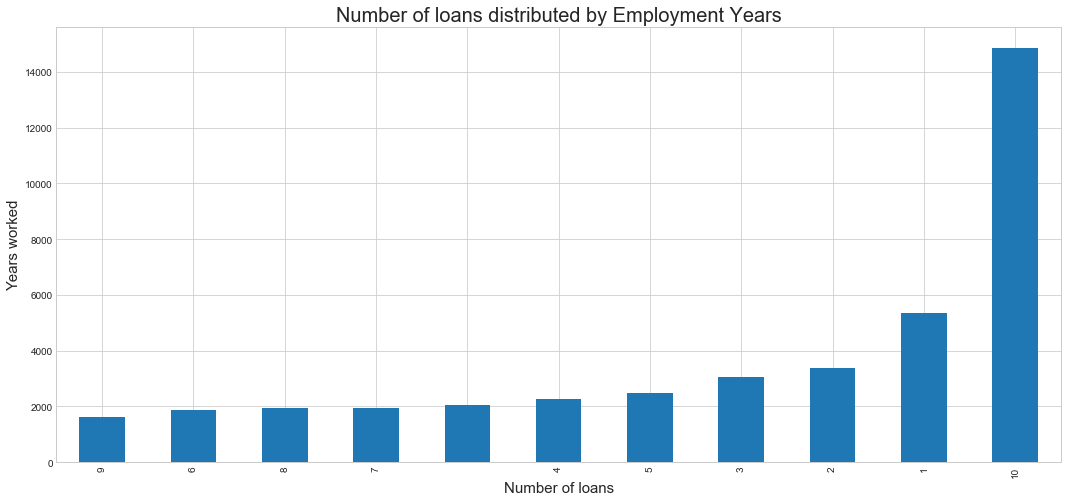

In [29]:
df['emp_length'].fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'].value_counts().sort_values().plot(kind='bar',figsize=(18,8))
plt.title('Number of loans distributed by Employment Years',fontsize=20)
plt.xlabel('Number of loans',fontsize=15)
plt.ylabel('Years worked',fontsize=15);

<p> Aplica o hot-encoding nas variáveis categóricas </p>

In [30]:
from sklearn import preprocessing

def label_encode(dataframe):
    count=0
    for col in dataframe:
        if dataframe[col].dtype == 'object':
            if len(list(dataframe[col].unique())) <= 2:     
                le = preprocessing.LabelEncoder()
                dataframe[col] = le.fit_transform(dataframe[col])
                count += 1
                print (col)
            
    print('%d columns were label encoded.' % count)

In [31]:
label_encode(df)

term
pymnt_plan
initial_list_status
application_type
4 columns were label encoded.


<p>One-Hot encode para as demais variáveis categóricas </p>

In [32]:
df = pd.get_dummies(df)
print(df.shape)

(40796, 163)


<p> Para a coluna `mhts_since_last_delinq` os valores faltantes serão preenchidos com a mediana da variável </p>

In [33]:
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(df['mths_since_last_delinq'].median())

<p> Removendo os demais valores faltantes </p>

In [34]:
df.dropna(inplace=True)

<h2> Modelagem </h2>

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

<p>Separando o dataset em base de Treino e base de Testes </p>

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('target',axis=1),
    df['target'],
    test_size=0.15,
    random_state=int(np.random.random_sample()*100))

<p> Liberando memória </p>

In [37]:
del raw_data
gc.collect()

1350

<p>Padronizando as features </p>

In [38]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<p> Tratando dados desbalanceados através de sampling </p>

In [39]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12, ratio = 1.0)
x_train_r, y_train_r = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [40]:
log_reg = LogisticRegression(C = 0.0001,random_state=21)
log_reg.fit(x_train_r, y_train_r)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=21,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [41]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))    

In [42]:
print_score(log_reg, x_train_r, y_train_r, X_test, y_test, train=False)

Test Result:

accuracy score: 0.7626

Classification Report: 
              precision    recall  f1-score   support

          0       0.22      0.82      0.35       475
          1       0.98      0.76      0.85      5645

avg / total       0.92      0.76      0.82      6120


Confusion Matrix: 
 [[ 390   85]
 [1368 4277]]



In [45]:
from sklearn import tree

tree = tree.DecisionTreeClassifier()
tree.fit(x_train_r,y_train_r)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [46]:
print_score(tree, x_train_r, y_train_r, X_test, y_test, train=False)

Test Result:

accuracy score: 0.9536

Classification Report: 
              precision    recall  f1-score   support

          0       0.69      0.74      0.71       475
          1       0.98      0.97      0.97      5645

avg / total       0.96      0.95      0.95      6120


Confusion Matrix: 
 [[ 350  125]
 [ 159 5486]]

